In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import files
files.upload()

In [ ]:
files.upload()

In [5]:
import pickle 
import numpy as np

In [6]:
with open("train_qa.txt", "rb") as f:
    train_data = pickle.load(f)

In [7]:
with open("test_qa.txt", "rb") as f:
    test_data = pickle.load(f)

In [8]:
type(test_data)
type(train_data)
len(test_data)
len(train_data)

list

In [12]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [13]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [14]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [15]:
train_data[0][2]

'no'

In [16]:
# Set up the vocabulary 

In [17]:
vocab = set() # this will hold the vocab

all_data = test_data + train_data

In [19]:
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [20]:
vocab.add('no')
vocab.add('yes')

In [21]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [22]:
vocab_len = len(vocab) + 1 # add an extra space to hold a 0 for Keras' pad sequences

max_story_len = max([len(data[0]) for data in all_data])

max_story_len

156

In [23]:
max_question_len = max([len(data[1]) for data in all_data])

max_question_len

6

### Vectorize Data

In [24]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [25]:
vocab_size = len(vocab) + 1

### Import Keras Packages

In [27]:
%%capture
!pip install keras

In [29]:
from keras.preprocessing.sequence import pad_sequences 
from keras.preprocessing.text import Tokenizer  

In [30]:
# int-encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

tokenizer.word_index

{'journeyed': 1,
 'is': 2,
 '.': 3,
 'discarded': 4,
 'football': 5,
 'mary': 6,
 'to': 7,
 'picked': 8,
 'milk': 9,
 'left': 10,
 'got': 11,
 '?': 12,
 'down': 13,
 'garden': 14,
 'kitchen': 15,
 'no': 16,
 'apple': 17,
 'went': 18,
 'travelled': 19,
 'grabbed': 20,
 'there': 21,
 'sandra': 22,
 'took': 23,
 'hallway': 24,
 'in': 25,
 'moved': 26,
 'put': 27,
 'daniel': 28,
 'yes': 29,
 'back': 30,
 'bedroom': 31,
 'dropped': 32,
 'the': 33,
 'bathroom': 34,
 'up': 35,
 'john': 36,
 'office': 37}

In [32]:
train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:

    train_story_text.append(story)
    train_question_text.append(question)

train_story_seq = tokenizer.texts_to_sequences(train_story_text)

print(len(train_story_text))
len(train_story_seq)

10000


10000

### Functionalize Vectorization Process

In [34]:
def vectorize_stories(data, 
                      word_index=tokenizer.word_index, 
                      max_story_len=max_story_len, 
                      max_question_len=max_question_len):
    '''
    INPUT:

    data: consisting of Stories, Queries, and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story ( used for pad_sequences function )
    max_question_len: length of the longest question ( used for pad_sequences function )

    OUTPUT:

        Vectorizes the stories, questions, and answers into padded sequences. 
        First loop for every story,query,answer in the data. Then convert raw words
        to a word index value. Then append each set to their appropriate output list.
        Once converted --> words to numbers, pad the sequences so they are all of equal length.

    Returns: above output explanation in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    # X = Stories
    X = []
    # Xq = Query
    Xq = []
    # Y = Correct Answer
    Y = []

    for story, query, answer in data:
        
        # Grab word index for every word in the story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]

        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # INdex 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)

        # Now that y is all zeros and it's known it is just Yes/No
        ## We can use numpy logic to create this assignment
        y[word_index[answer]] = 1

        # Append each set of story,query,answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Finally, pad the sequences based on their max length so the RNN can be trained
    ## on uniformly long sequences. RETURN TUPLE FOR UNPACKING!!!
    return (pad_sequences(X, maxlen=max_story_len), 
            pad_sequences(Xq, maxlen=max_question_len), 
            np.array(Y))
    

In [35]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

print(inputs_test)
queries_test

[[ 0  0  0 ... 33 31  3]
 [ 0  0  0 ... 33 14  3]
 [ 0  0  0 ... 33 14  3]
 ...
 [ 0  0  0 ... 33 17  3]
 [ 0  0  0 ... 33 14  3]
 [ 0  0  0 ... 17 21  3]]


array([[ 2, 36, 25, 33, 15, 12],
       [ 2, 36, 25, 33, 15, 12],
       [ 2, 36, 25, 33, 14, 12],
       ...,
       [ 2,  6, 25, 33, 31, 12],
       [ 2, 22, 25, 33, 14, 12],
       [ 2,  6, 25, 33, 14, 12]], dtype=int32)

In [36]:
print(answers_test)
print(sum(answers_test))
print(tokenizer.word_index['yes'])
tokenizer.word_index['no']

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 503.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 497.   0.   0.   0.   0.   0.   0.   0.   0.]
29


16

## Creating the Model

In [37]:
# IMPORT RELATIVE PACKAGES
from keras.models import Sequential, Model 
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout 
from keras.layers import add, dot, concatenate 
from keras.layers import LSTM

### Placeholders for Inputs

Recall we technically have two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.


In [38]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

## Encoders

### Input Encoder m

In [39]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

### Input Encoder c

In [40]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

### Question Encoder

In [41]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))


### Encode the Sequences

In [42]:
# encode input sequence and questions ( which are indicies )
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [43]:
# USE DOT PRODUCT TO COMPUTE THE MATCH BETWEEN FIRST INPUT VECTOR AND QUERY
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation("softmax")(match)

In [44]:
# Add match matrix with the second input vector sequence
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [45]:
# CONCATENATE
answer = concatenate([response, question_encoded])

In [46]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [47]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)

In [48]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [49]:
answer = Activation("softmax")(answer)

# build final model 
model = Model([input_sequence, question], answer)
model.compile(optimizer="rmsprop", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [51]:
# TRAIN
history = model.fit([inputs_train, queries_train],
                    answers_train,
                    batch_size=32,
                    epochs=120,
                    validation_data=([inputs_test, queries_test],
                                     answers_test))

Epoch 1/120
313/313 [==============================] - 9s 18ms/step - loss: 0.9103 - accuracy: 0.4932 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 2/120
313/313 [==============================] - 5s 16ms/step - loss: 0.7030 - accuracy: 0.4979 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6961 - accuracy: 0.4995 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 4/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6946 - accuracy: 0.4972 - val_loss: 0.6947 - val_accuracy: 0.4970
Epoch 5/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6952 - accuracy: 0.4928 - val_loss: 0.6932 - val_accuracy: 0.4750
Epoch 6/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6943 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 7/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6947 - accuracy: 0.4985 - val_loss: 0.6933 - val_accuracy:

### Save Model

In [52]:
filename = "chatteral_thinking_120_epochs.h5"
model.save(filename)

## Evaluating Model

### Plotting Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


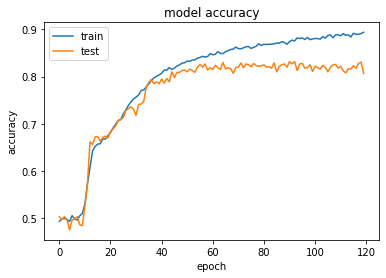

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

### Evaluation on Given Test Set

In [58]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [59]:
story = ' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [60]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [61]:
print("True Test Answer from Data is: ", test_data[0][2])

True Test Answer from Data is:  no


In [62]:
# Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.97968125


In [63]:
## test run 

In [64]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [65]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [66]:
my_question = "Is the football in the garden ?"

In [67]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [68]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [69]:
my_story, my_ques,my_ans = vectorize_stories(mydata)

In [70]:
pred_results = model.predict(([my_story, my_ques]))

In [71]:
#### GENERATE FINAL PREDICTION FROM MODEL
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key 

print(f"Predicted answer is: {k}")
print(f"Probability of Certainty was: {pred_results[0][val_max]}")

Predicted answer is: yes
Probability of Certainty was: 0.997403085231781
